In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def load_dataset(smile_path, non_smile_path):
    smile_images = []
    non_smile_images = []
    labels = []

    for filename in os.listdir(smile_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(smile_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (160, 160))
                smile_images.append(img)
                labels.append(1)  # 1 -> smile

    for filename in os.listdir(non_smile_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(non_smile_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (160, 160))
                non_smile_images.append(img)
                labels.append(0)  # 0 -> non-smile

    images = np.array(smile_images + non_smile_images)
    labels = np.array(labels)

    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    return train_images, train_labels, val_images, val_labels

smile_path = '/content/drive/MyDrive/GENKI4k/Dataset/cropped_smile'
non_smile_path = '/content/drive/MyDrive/GENKI4k/Dataset/cropped_non_smile'
train_images, train_labels, val_images, val_labels = load_dataset(smile_path, non_smile_path)

print("Training data shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

print("Number of smiling faces in training set:", np.sum(train_labels == 1))
print("Number of non-smiling faces in training set:", np.sum(train_labels == 0))
print("Number of smiling faces in validation set:", np.sum(val_labels == 1))
print("Number of non-smiling faces in validation set:", np.sum(val_labels == 0))


Mounted at /content/drive
Training data shape: (3148, 160, 160, 3)
Training labels shape: (3148,)
Validation data shape: (787, 160, 160, 3)
Validation labels shape: (787,)
Number of smiling faces in training set: 1711
Number of non-smiling faces in training set: 1437
Number of smiling faces in validation set: 428
Number of non-smiling faces in validation set: 359


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess the image data
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

# Load the pre-trained VGG19 model (excluding the top classification layer)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(160, 160, 3))


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [4]:
# Build the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 5, 5, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,422,721 (77.91 MB)

 Trainable params: 9,835,521 (37.52 MB)

 Non-trainable params: 10,587,200 (40.39 MB)

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_images)

In [6]:
# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=10,  # Adjust the number of epochs
    validation_data=(val_images, val_labels)
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 59s 399ms/step - accuracy: 0.5755 - loss: 0.8335 - val_accuracy: 0.5527 - val_loss: 0.6324
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 239ms/step - accuracy: 0.7834 - loss: 0.5043 - val_accuracy: 0.8196 - val_loss: 0.3976
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 245ms/step - accuracy: 0.8490 - loss: 0.3477 - val_accuracy: 0.7306 - val_loss: 0.6074
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.8751 - loss: 0.3180 - val_accuracy: 0.7675 - val_loss: 0.4548
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.8596 - loss: 0.3468 - val_accuracy: 0.9085 - val_loss: 0.2561
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.9018 - loss: 0.2569 - val_accuracy: 0.9365 - val_loss: 0.1982
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - accuracy: 0.9102 - loss: 0.2294 - val_accuracy: 0.8767 - val_loss: 0.3115
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 230ms/step - accuracy: 0.9128 - loss: 0.2407 - val_accuracy: 0.907

In [7]:
# Save the model to Google Drive
model_save_path = '/content/drive/MyDrive/smile_detection_model_VGG_HF17_v6.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/smile_detection_model_VGG_HF17_v6.h5


In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(val_images, val_labels)
print('Validation Loss:', loss)
print('Validation Accuracy:', accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9467 - loss: 0.1812
Validation Loss: 0.17929725348949432
Validation Accuracy: 0.9466328024864197


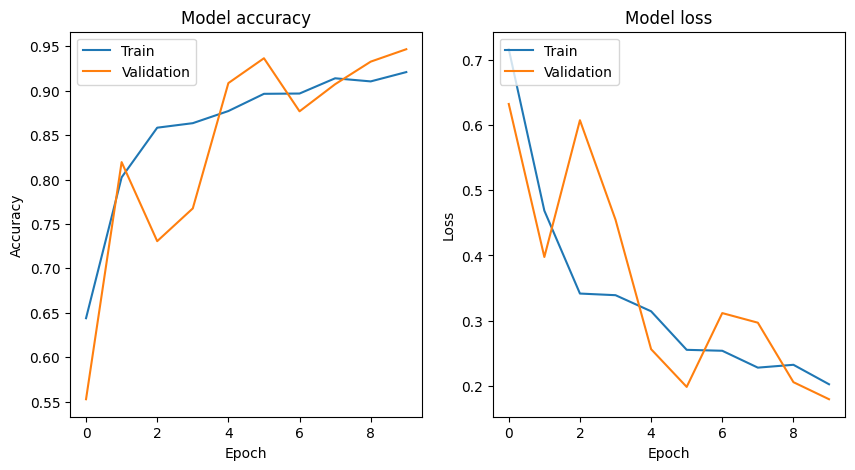

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()